In [ ]:
import os 
import operator
import json
import seaborn as sns
import pylab as pl
import pandas as pd
import numpy as np
import datetime
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
%pylab inline

## TIME SERIES ANALYSIS 

## Goal: Find outliers, trends and periodicity in the MTA turnstile data

#### Data: 
MTA Subway fares. It is a complete dataset of rides logged by card swipes for 600 Manhattan stations. It contains 23 different subway card types (e.g. monthly pass, daily pass, Act for Disability pass...) as follows: 

#### Task 1:

* Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
* Identify it and figure out what it is due to.

In [17]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [18]:
#read the datacube

mta = np.load("MTA_Fare.npy")
mta.shape

(600, 23, 194)

In [19]:
#convert mta type to float so that NaN values can be added 
mta = mta.astype(float)

#clean up the data 
mta[mta==-1] = np.nan

In [20]:
#create a date range

mta_date = pd.date_range('05/21/2010', periods = 194, freq = 'W')
print mta_date.shape

(194,)


In [21]:
#create an array of the sum of swipes across 600 stations over 194 weeks (all metrocard types)
mta_sum = np.nansum(mta, axis = 1)
print mta_sum.shape

(600, 194)


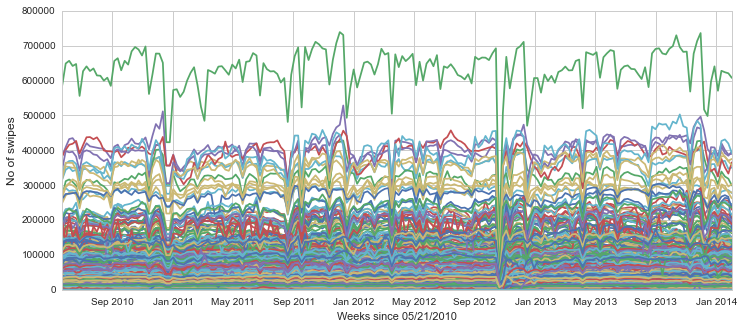

In [22]:
plt.figure(figsize=(12,5), dpi = 200)
ax = pl.plot(mta_date, np.transpose(mta_sum))
pl.ylabel('No of swipes', fontsize = 12)
pl.xlabel('Weeks since 05/21/2010')

In [23]:
#find means and standard deviations of the number of swipes at each station (to find outliers)
mta_mean = np.nanmean(mta_sum, axis = 1)
mta_std = np.nanstd(mta_sum, axis = 1)
print mta_mean, mta_std

[  1.19380969e+05   2.06625155e+04   7.24413918e+03   1.90176340e+04
   2.03715670e+04   2.22706753e+04   1.38575619e+04   1.28940722e+04
   1.13197990e+04   1.91203376e+05   3.56733423e+05   3.49854330e+05
   1.08266397e+05   1.84694351e+05   1.25090196e+05   4.32336701e+04
   1.83743299e+05   2.76968418e+05   8.91681289e+04   3.23156686e+05
   2.15042649e+05   4.04874660e+05   2.87989675e+05   1.10743299e+05
   1.66405021e+05   2.57731959e-02   1.33484918e+05   1.31936485e+05
   2.80386716e+05   1.18023521e+05   1.93084701e+05   1.89762361e+05
   3.90171495e+05   4.48527732e+04   1.36183670e+05   2.84681082e+04
   3.21657784e+04   1.07197887e+04   2.81359072e+04   4.34656495e+04
   1.09435381e+05   2.48247165e+04   1.24495407e+05   1.93115149e+05
   1.29016778e+05   3.95005804e+05   2.18560634e+05   5.81991443e+04
   1.30195144e+05   1.51009995e+05   2.08423222e+05   3.10121959e+04
   1.15199438e+05   6.17420928e+04   2.70509892e+05   6.07656753e+04
   2.08226433e+05   2.39280206e+04

In [9]:
#create thresholds of 3 standard deviations from the mean
thresholds = [mta_mean + 3*mta_std, mta_mean - 3*mta_std]
print thresholds

[array([  2.30396444e+05,   7.66234556e+04,   1.01825810e+04,
         2.84846227e+04,   2.77070633e+04,   3.06642048e+04,
         1.87053288e+04,   1.91424680e+04,   1.55235996e+04,
         2.71396355e+05,   4.53446404e+05,   4.49217208e+05,
         1.45690790e+05,   2.52987909e+05,   1.86536665e+05,
         5.94206383e+04,   2.63452563e+05,   3.68546388e+05,
         1.16452964e+05,   4.39260320e+05,   2.87174177e+05,
         5.25293279e+05,   3.66766581e+05,   1.42792856e+05,
         2.20842694e+05,   5.01147200e-01,   1.88170849e+05,
         2.09504553e+05,   3.86170870e+05,   1.89556793e+05,
         2.52627526e+05,   2.64037511e+05,   5.08028864e+05,
         6.05324920e+04,   1.83341141e+05,   6.66091961e+04,
         5.01165337e+04,   1.66581093e+04,   4.60564995e+04,
         6.01726343e+04,   1.60267250e+05,   4.37499270e+04,
         1.74927543e+05,   2.74071266e+05,   1.78842644e+05,
         5.15536906e+05,   3.00195796e+05,   8.20755433e+04,
         1.71555427e+05

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

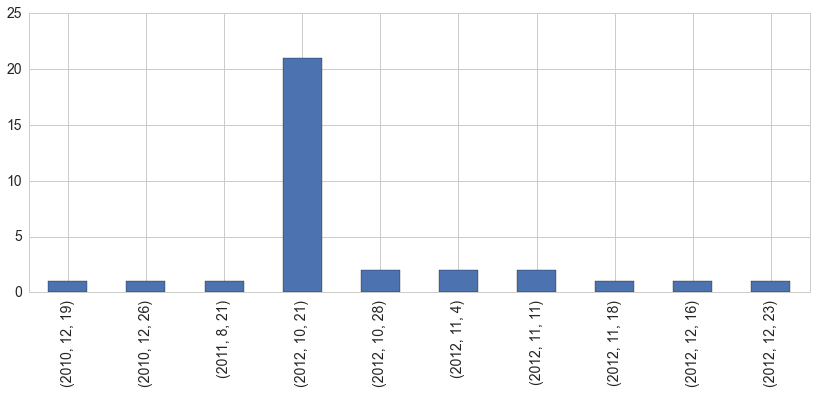

In [10]:
# detect outliers 

mta_sum = pd.DataFrame(mta_sum)
events = pd.Series()
for i in range(23):
    thresholds = [mta_sum.loc[i,:].mean() + 3*mta_sum.loc[i,:].std(), 
                  mta_sum.loc[i,:].mean() - 3*mta_sum.loc[i,:].std()]

#detect event

    event = (mta_sum.loc[i,:]<thresholds[1])
    events = pd.concat([events, pd.Series(mta_date[event.index[event==True]])], axis=0, ignore_index=True)

events.sort()
events.groupby([events.dt.year, events.dt.month, events.dt.day]).count().plot(kind="bar", fontsize=14, figsize = (14,5))
pl.xticks(rotation = 90)


#### Comments:
The event spotted in the graph above is 21 Oct 2012, when the Hurricane Sandy happened. 

#### Task 2:

* Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [11]:
##create an array of the sum of swipes across 600 stations over 194 weeks by rider type
mta_ridetype = np.nansum(mta, axis = 0)
print mta_ridetype.shape

(23, 194)


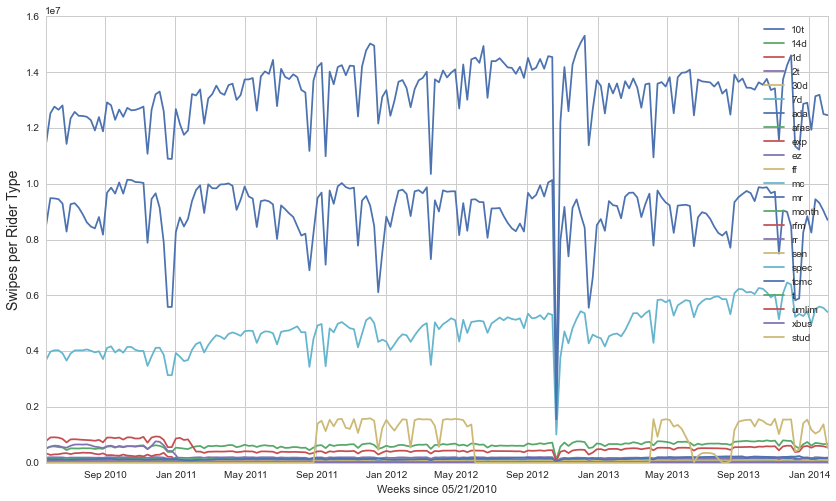

In [12]:
plt.figure(figsize=(14,8), dpi=200)
ax = pl.plot(mta_date, np.transpose(mta_ridetype))
pl.ylabel('Swipes per Rider Type', fontsize = 14)
pl.xlabel('Weeks since 05/21/2010')
pl.legend(ridetype)

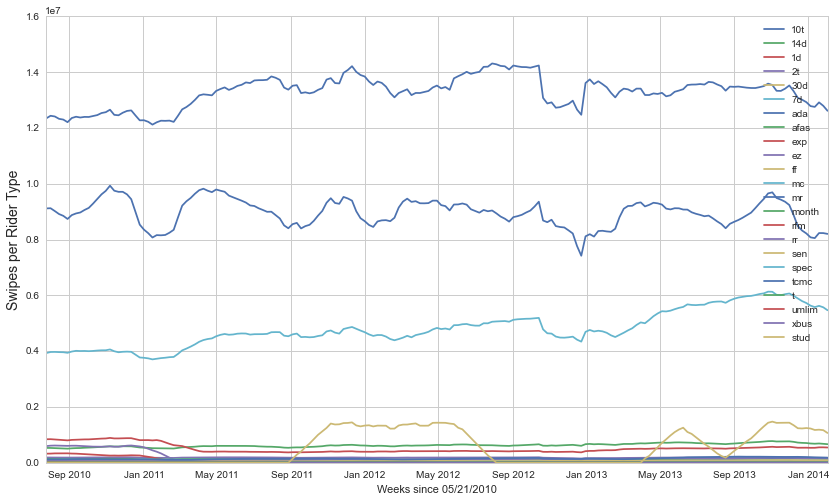

In [13]:
#find the rolling mean for each ride type 
mta_rollingmean = pd.rolling_mean(np.transpose(mta_ridetype), 10)
plt.figure(figsize=(14,8), dpi = 200)
ax = pl.plot(mta_date, mta_rollingmean)
pl.ylabel('Swipes per Rider Type', fontsize = 14)
pl.xlabel('Weeks since 05/21/2010')
pl.legend(ridetype)

In [14]:
#calculate the ratio of the flux near the beginning to the flux near the end of the time series

mta_ratio = mta_rollingmean[10,:]/mta_rollingmean[193,:]
print mta_ratio

[  9.85855761e-01   7.96898334e-01   9.01896857e-01   1.07217516e+00
   9.83155326e-01   7.26253084e-01   1.11214933e+00   4.80765217e+03
   9.42633429e+04   6.82381556e+05   1.23714609e+00   8.30622261e-01
   3.89558171e-05   1.74222625e+00   1.54426917e+00   3.87513943e-01
   3.47208425e-01   5.46373828e-02   6.53059649e-01   9.80984190e-01
   1.26020779e+00   6.18746842e-01   0.00000000e+00]


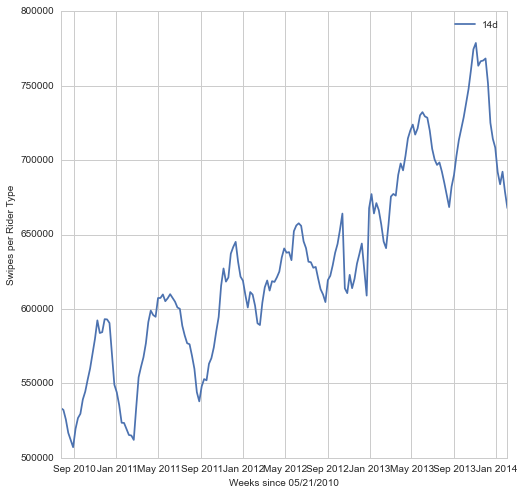

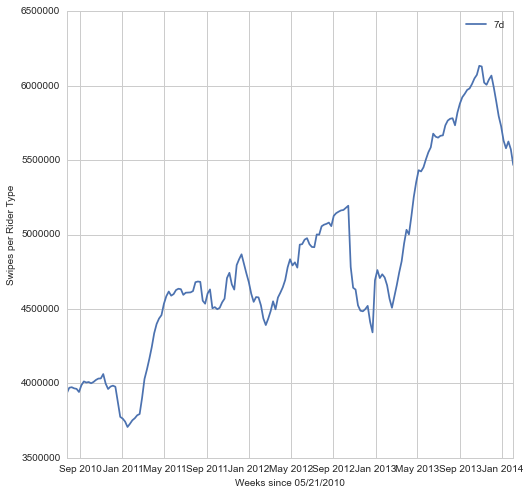

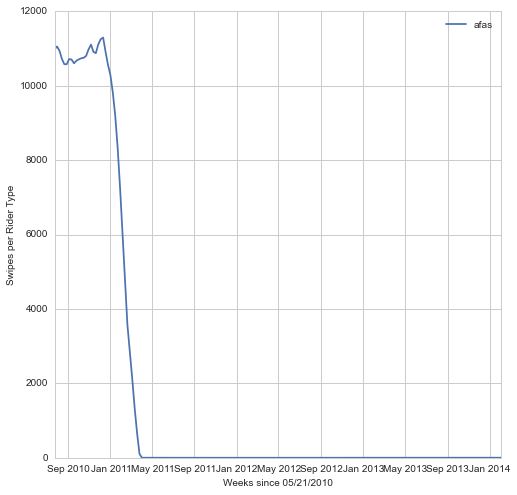

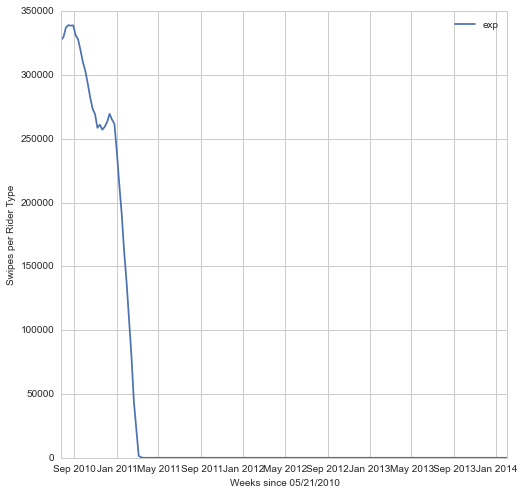

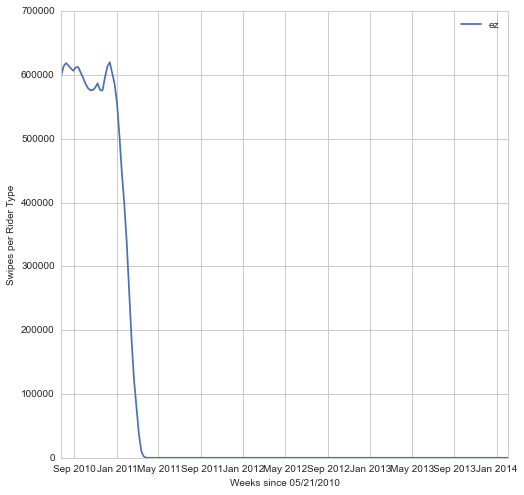

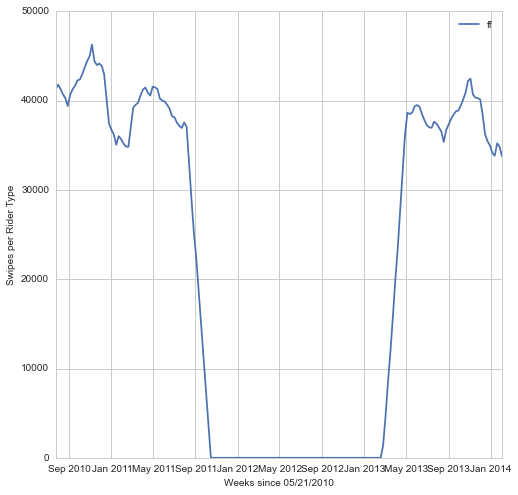

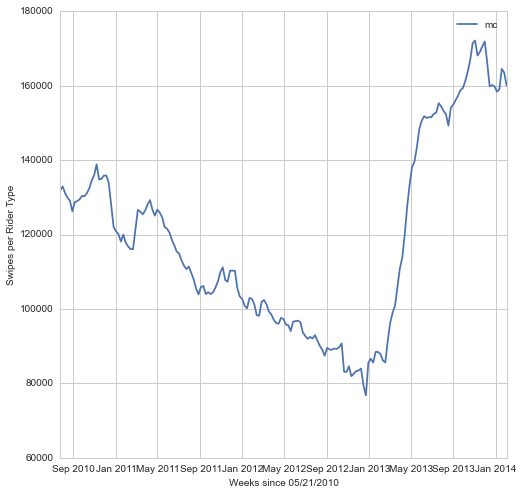

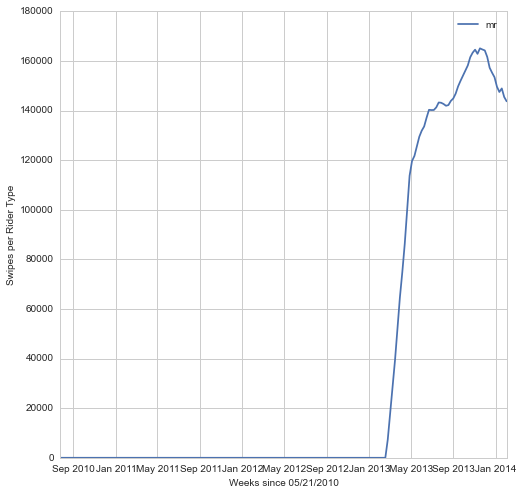

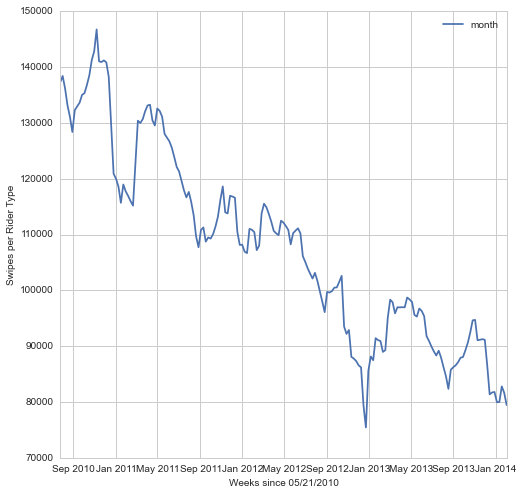

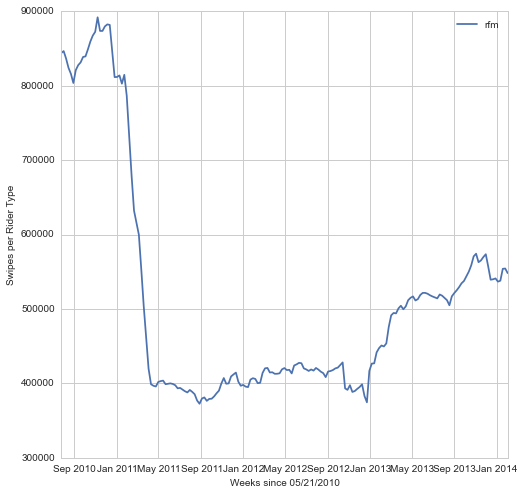

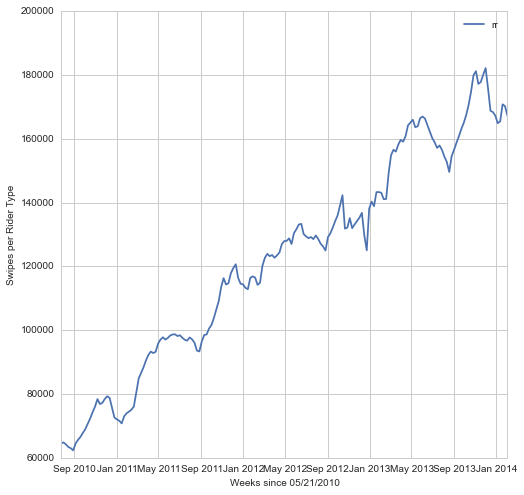

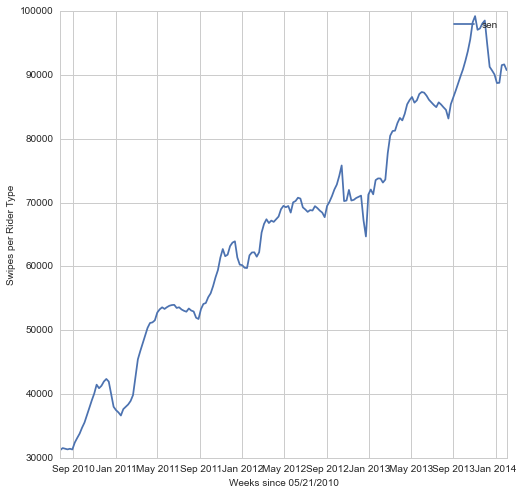

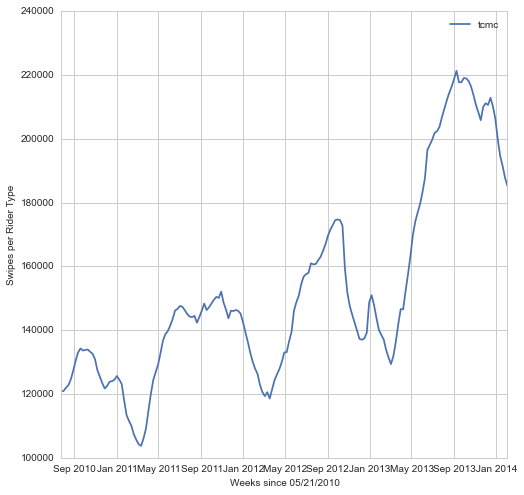

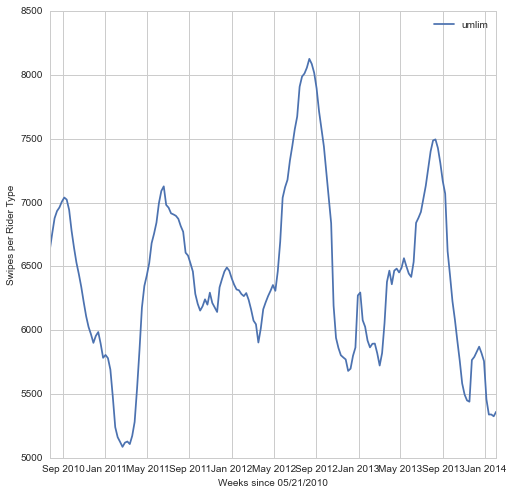

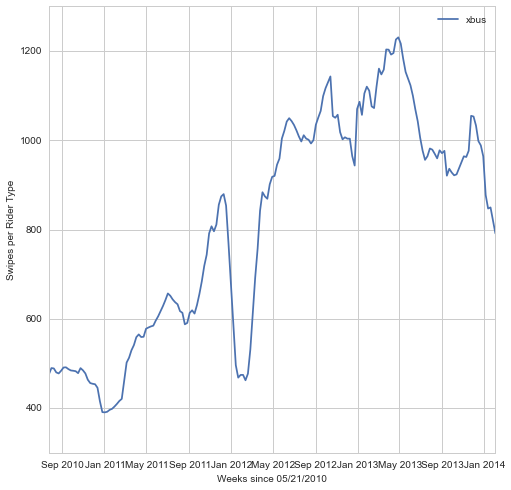

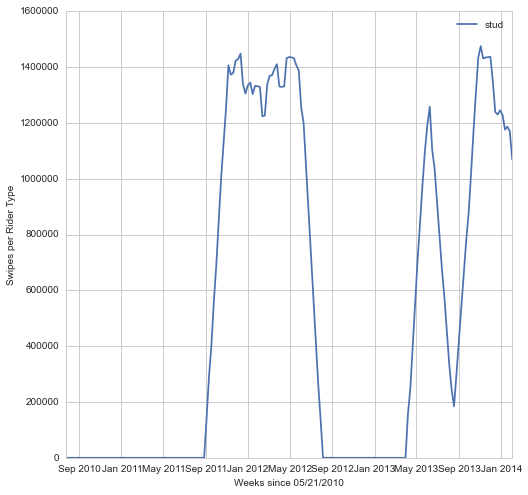

In [15]:
#all the rider types that have a ratio between 0.9 and 1.1 signal that they do not change in popularity
#They are 10t (0th), 1d (2nd), 2t (3rd), 30d (4th), ada (6th), and t (19th)
#Thus, those rider types would not be used. 

relevant_type = [1,5,7,8,9,10,11,12,13,14,15,16,18,20,21,22]
for i in relevant_type:
    plt.figure(figsize=(8,8), dpi=200)
    ax = pl.plot(mta_date, mta_rollingmean[:,i])
    pl.ylabel('Swipes per Rider Type', fontsize = 10)
    pl.xlabel('Weeks since 05/21/2010', fontsize = 10)
    pl.legend(ridetype[i:])

#### Comments:
The types of rider that have an upward trend include: 14 day, 7 day, railroad, senior, special, transit check and express bus. 
The types of rider that have a downward trend include: monthly passes. 

In [25]:
rate = [1, 5, 13, 15, 16, 17, 18, 21]
for i in rate: 
    if i != 13: 
        print "%s rider type has an increasing rate at %r" %(ridetype[i], mta_ratio[i])
    else:
        print "%s rider type has an decreasing rate at %r" %(ridetype[i], 1-mta_ratio[i])

14d rider type has an increasing rate at 0.79689833379178909
7d rider type has an increasing rate at 0.72625308425552371
month rider type has an decreasing rate at -0.74222624958310535
rr rider type has an increasing rate at 0.38751394307042847
sen rider type has an increasing rate at 0.34720842483661574
spec rider type has an increasing rate at 0.054637382778663521
tcmc rider type has an increasing rate at 0.65305964862261268
xbus rider type has an increasing rate at 0.61874684183931283


#### Task 3:

* Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). 
* Can you figure out what the periodic peak in rides is due to?

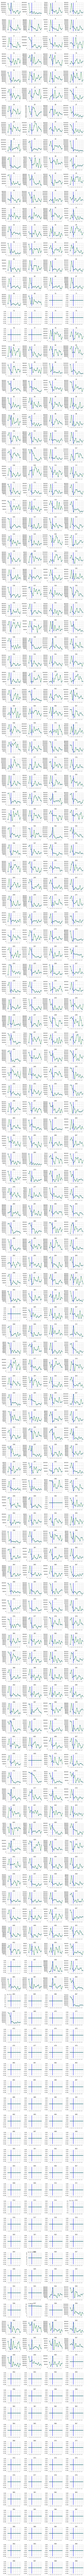

In [27]:
mta_sum = pd.DataFrame(mta_sum)
fig = plt.figure(figsize=(20,400))
for i in range(600):
        ax = fig.add_subplot(200,4,i+1)
        f = np.abs(np.fft.rfft(mta_sum.loc[i,:]))
        ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms = 6)
        ax.set_title("%s" %(str(i)))
        ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
        ax.set_xlim(0,1.0/15)
        ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=5)
        plt.axvline(1.0/52)
        plt.subplots_adjust(wspace=.5, hspace=.5, left=.1, right=.5, top=1, bottom=.1)

In [28]:
power = {}
for i in range(600):
    power[i] = np.abs(np.fft.rfft(mta_sum.loc[i,:]))[4]
dict(sorted(power.iteritems(), key = operator.itemgetter(1), reverse = True)[:4])

{0: 2980160.6355953491,
 150: 2931895.8769513383,
 194: 2950388.929214194,
 327: 2402218.5809588572}

#### Comments:

* By eye calculation: stations with the highest yearly periodicity are no. 0, 150, 194, and 327. 
* By calculation, those four stations prove to have the highest power spectrum between 2.5 and 3 millions. 